# Analysis of Public Interest on Initial Public Offering (IPO) on Bursa Malaysia

Initial Public Offering (IPO) is where shares of a company are offered to investors, both institutional and the public.

Here I look at public interest towards IPO on Bursa Malaysia over years 2017 till 2022 (up till January, i.e only Coraza and Sen Heng for this year).

Data was collected from the Internet 2017 till 2022. Sources are online only, including Bursa Malaysia, The Edge websites and many more.

Data was collected manually, hence there could be errors in the numbers - read that again - data was collected manually, hence there could be errors in the numbers. I also made no effort to verify the data after initial collection.

Only IPOs that could be subscribed by the public in the Main and ACE markets was included, e.g IPOs on the LEAP market or IPOs or ETFs were not included. 

<b>This exercise is for entertainment purpose only. Do not trade shares based on this exercise. Trading shares involve capital loss and emotional pain. Please consult your investment advisor before embarking on any financial exercise.</b>

For the exercises below, I divide the analyses by listing price below RM1, and listing price at least RM1.

In [1]:
import pandas as pd
from statistics import stdev
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("IPO_2017to2022.csv")
df.head()

,TICKER,MARKET,YEAR,LISTPRICE,VOLUMEIPODAY,OPENPRICEIPODAY,HIGHESTPRICEIPODAY,CLOSINGPRICEIPODAY,NEWSHARES,TOTALAPPLICATIONS,...,XBUMIAPPLICATIONS,XBUMIAPPLICATIONSHARES,XBUMIBALLOTINGOSCBED,ELIGPERSONSSHARES,PVPLACEMENTSHARES,OFFERFORSALE,CAPITALRAISED,PUBLICISSUENEWSHARES,ENLARGEDSHARECAPITAL,MARKETCAPONLISTING
0,CORAZA,ACE,2022,0.28,1937841,0.700,0.705,0.645,2140000.0,26781.0,...,14299.0,1.850000e+09,171.40,21400000.0,96400000.0,21400000.0,33000000.0,117800000.0,428300000.0,119900000.0
1,SENHENG,MAIN,2022,1.07,1635486,0.900,1.040,0.855,30000000.0,16548.0,...,9679.0,2.499200e+08,15.66,22500000.0,149500000.0,139500000.0,NaN,250000000.0,NaN,NaN
2,TUJUSETIA,MAIN,2021,0.70,1145707,0.775,0.875,0.740,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YENHER,MAIN,2021,0.95,618271,0.995,1.000,0.900,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CTOS,MAIN,2021,1.10,3663593,1.500,1.760,1.620,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that here many columns such as NEWSHARES and TOTALAPPLICATIONS are not populated, as they are used in this current analysis.

### Feature Engineering and Data Clean-Up

In [3]:
# drop rows if stock hasn't IPOed yet
df = df[df['VOLUMEIPODAY'].notna()]

In [4]:
# Create following columns:
# % difference between list price vs opening price on IPO day
# % difference between list price vs highest price on IPO day
# % difference between opening price on IPO day vs closing price on IPO day
# % difference between opening price on IPO day vs highest price on IPO day

df['LISTVSOPENING_PCT'] = df['OPENPRICEIPODAY']/df['LISTPRICE']*100 - 100
df['LISTVSHIGHEST_PCT'] = df['HIGHESTPRICEIPODAY']/df['LISTPRICE']*100 - 100
df['LISTVSCLOSING_PCT'] = df['CLOSINGPRICEIPODAY']/df['LISTPRICE']*100 - 100

In [5]:
# remove Lotte Chemical as it was undersubscribed
df = df[df['TICKER']!='LOTTE']

In [6]:
df.shape

(66, 28)

In [7]:
# grab all available years
years = df['YEAR'].unique().tolist()[::-1]
years

[2017, 2018, 2019, 2020, 2021, 2022]

## Measuring Subscription Interest: Oversubscription Rate by Year

I first ask this question: how does public interest towards IPOs change over the years? I am interested in this question since I have encountered anecdotes from acquaintances and friends that it is getting harder to get any units from IPO offering since past years.

In [8]:
# function to calculate bar height, bar error bars and counts, after dividing by RM<1 and RM>=1

def calculate_bardata(years, df, targetvar):

    barheight = {}
    barheight['lt1'] = {}
    barheight['mt1'] = {}

    barerr = {}
    barerr['lt1'] = {}
    barerr['mt1'] = {}

    count = {}
    count['lt1']={}
    count['mt1']={}

    for year in years:
        # for < RM1
        df_series_lt1 = df[((df['YEAR']==year)  & (df['LISTPRICE']<1))][targetvar]

        count['lt1'][year] = df_series_lt1.count()
        mean_year_lt1 = round(df_series_lt1.mean(),2)

        barheight['lt1'][year] = mean_year_lt1
        if df_series_lt1.count() >1:
            barerr['lt1'][year] = round(stdev(df_series_lt1),2)
        else:
            barerr['lt1'][year] = 0

        df_series_mt1 = df[((df['YEAR']==year)  & (df['LISTPRICE']>=1))][targetvar]

        count['mt1'][year] = df_series_mt1.count()
        mean_year_mt1 = round(df_series_mt1.mean(),2)

        barheight['mt1'][year] = mean_year_mt1
        if df_series_mt1.count() >1:
            barerr['mt1'][year] = round(stdev(df_series_mt1),2)
        else:
            barerr['mt1'][year] = 0
            
    return count, barheight, barerr

In [9]:

count, barheight, barerr = calculate_bardata(years, df, 'TOTALBALLOTINGOSCBED')

print("For listing price <= RM1:")
for year in years:
    print(str(year) + '(' + str(count['lt1'][year]) + '): mean ' + str(barheight['lt1'][year]) + 
         ', stdev ' + str(barerr['lt1'][year]))

print()
print("For listing price > RM1:")
for year in years:
    print(str(year) + '(' + str(count['mt1'][year]) + '): mean ' + str(barheight['mt1'][year]) + 
         ', stdev ' + str(barerr['mt1'][year]))


For listing price <= RM1:
2017(7): mean 36.03, stdev 23.4
2018(10): mean 18.15, stdev 13.09
2019(13): mean 13.3, stdev 8.81
2020(10): mean 30.98, stdev 25.01
2021(14): mean 75.15, stdev 53.15
2022(1): mean 132.5, stdev 0

For listing price > RM1:
2017(3): mean 6.34, stdev 2.3
2018(1): mean 1.16, stdev 0
2019(2): mean 4.01, stdev 0.53
2020(1): mean 3.91, stdev 0
2021(3): mean 22.23, stdev 4.68
2022(1): mean 10.44, stdev 0


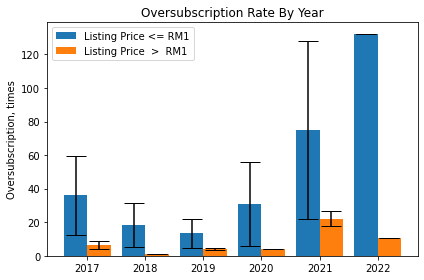

In [10]:
fig, ax = plt.subplots()
xpos = np.arange(len(barerr['lt1']))
width = 0.4
plt.bar(xpos-0.2, list(barheight['lt1'].values()), width, yerr=list(barerr['lt1'].values()), ecolor='black', capsize=10)
plt.bar(xpos+0.2, list(barheight['mt1'].values()), width, yerr=list(barerr['mt1'].values()), ecolor='black', capsize=10)

ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('Oversubscription, times')
plt.title('Oversubscription Rate By Year')
plt.legend(["Listing Price <= RM1", "Listing Price  >  RM1"])

plt.tight_layout()
plt.show()

Here you see from 2017 till 2019, oversubscription for IPOs goes down. Interestingly, things changed dramatically since then, where it more than doubled from 2019 to 2020, and again in 2020 to 2021 (for price less than RM1).
Also note that oversubcription is much lower in general for IPOs with listing price more than RM1.

The huge increase in ovesubscription rate starting in 2020 is consistent with the heightened interest from the public in the stock market as stay-at-home orders were issued due to Covid: we did not only see higher trading volume on the open market in general (as have been covered by many analysts and reports), we also see higher subscription to the IPOs offered.

(Note that for 2022 we have only 1 IPO so far so the analysis for 2022 is ongoing)

## Measuring Speculative Activity on IPO Day: Volume on IPO day by Year
I now ask the question, if there is an increase in public interest from 2019 to 2021 as measured by the oversubscription rate, does this translate into higher trading volume on the counter on IPO day?

One scenario that I could imagine is that, could it be that other people who did not get the IPO, also participate on the counter on IPO day (although this can't be proven directly unless we track the trading tickets that day and compare their executers vs list of IPO awardees)?

In [11]:
count, barheight, barerr = calculate_bardata(years, df, 'VOLUMEIPODAY')
print("For listing price <= RM1:")
for year in years:
    print(str(year) + '(' + str(count['lt1'][year]) + '): mean ' + str(barheight['lt1'][year]) + 
         ', stdev ' + str(barerr['lt1'][year]))

print()
print("For listing price > RM1:")
for year in years:
    print(str(year) + '(' + str(count['mt1'][year]) + '): mean ' + str(barheight['mt1'][year]) + 
         ', stdev ' + str(barerr['mt1'][year]))


For listing price <= RM1:
2017(7): mean 1178970.71, stdev 1000184.04
2018(10): mean 1010671.4, stdev 591685.52
2019(13): mean 1644805.92, stdev 1310669.49
2020(10): mean 2046393.3, stdev 750481.12
2021(14): mean 1583495.0, stdev 849490.25
2022(1): mean 1937841.0, stdev 0

For listing price > RM1:
2017(3): mean 282241.67, stdev 339303.22
2018(1): mean 736832.0, stdev 0
2019(2): mean 1325753.0, stdev 1171305.41
2020(1): mean 4101546.0, stdev 0
2021(3): mean 2373199.0, stdev 1126551.55
2022(1): mean 1635486.0, stdev 0


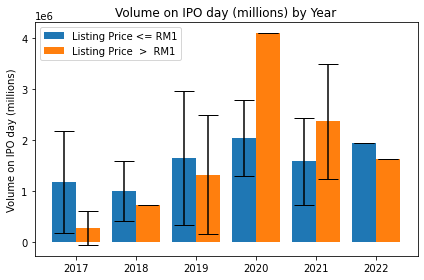

In [12]:
fig, ax = plt.subplots()
xpos = np.arange(len(barerr['lt1']))
width = 0.4
plt.bar(xpos-0.2, list(barheight['lt1'].values()), width, yerr=list(barerr['lt1'].values()), ecolor='black', capsize=10)
plt.bar(xpos+0.2, list(barheight['mt1'].values()), width, yerr=list(barerr['mt1'].values()), ecolor='black', capsize=10)

ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('Volume on IPO day (millions)')
plt.title('Volume on IPO day (millions) by Year')
plt.legend(["Listing Price <= RM1", "Listing Price  >  RM1"])

plt.tight_layout()
plt.show()

Interestingly we see that 2020 is the year with highest volume on IPOed counter on IPO day (even though it was 2021 is the year with the highest oversubscription). In 2021 the volume on IPOed counter decreased a bit vis-a-vis 2020, but still slightly above 2019.

## Measuring Speculative Activity on IPO Day: % Difference between Listing vs Opening Price

Now we see a higher volume on average on the IPOed counter on IPO day in 2020 (and also 2021), does this translate into more price movement on that day? Specifically I am interested in seeing the percentage difference between:

1. listing price versus opening price (first matched ticket at 9AM)
2. listing price versus highest price at any time during IPO day.

Let's look at (1) first.

In [13]:
count, barheight, barerr = calculate_bardata(years, df, 'LISTVSOPENING_PCT')
print("For listing price <= RM1:")
for year in years:
    print(str(year) + '(' + str(count['lt1'][year]) + '): mean ' + str(barheight['lt1'][year]) + 
         ', stdev ' + str(barerr['lt1'][year]))

print()
print("For listing price > RM1:")
for year in years:
    print(str(year) + '(' + str(count['mt1'][year]) + '): mean ' + str(barheight['mt1'][year]) + 
         ', stdev ' + str(barerr['mt1'][year]))

For listing price <= RM1:
2017(7): mean 22.94, stdev 8.69
2018(10): mean 33.56, stdev 39.76
2019(13): mean 26.13, stdev 32.24
2020(10): mean 55.9, stdev 58.98
2021(14): mean 69.53, stdev 80.09
2022(1): mean 150.0, stdev 0

For listing price > RM1:
2017(3): mean 6.17, stdev 5.58
2018(1): mean -2.11, stdev 0
2019(2): mean 0.14, stdev 2.37
2020(1): mean 0.0, stdev 0
2021(3): mean 14.96, stdev 18.54
2022(1): mean -15.89, stdev 0


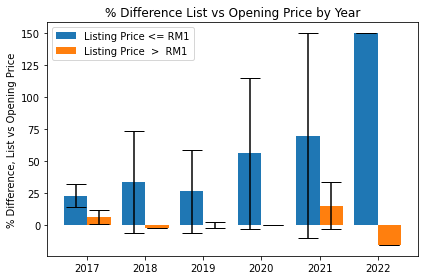

In [14]:
fig, ax = plt.subplots()
xpos = np.arange(len(barerr['lt1']))
width = 0.4
plt.bar(xpos-0.2, list(barheight['lt1'].values()), width, yerr=list(barerr['lt1'].values()), ecolor='black', capsize=10)
plt.bar(xpos+0.2, list(barheight['mt1'].values()), width, yerr=list(barerr['mt1'].values()), ecolor='black', capsize=10)

ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('% Difference, List vs Opening Price')
plt.title('% Difference List vs Opening Price by Year')
plt.legend(["Listing Price <= RM1", "Listing Price  >  RM1"])

plt.tight_layout()
plt.show()

We see that there is an increasing trend of higher opening price in 2020 and 2021, as opposed to previous years, and it's only for IPOs priced at less than RM1. Also note the really high standard deviation bars for each year, that suggests that while the average suggests an increasing trend, there is a huge variation within the same year itself.

## Measuring Speculative Activity on IPO Day: % Difference between Listing vs Highest Price

And now let's look at percentage difference between listing versus highest price on IPO day, per year

In [15]:
count, barheight, barerr = calculate_bardata(years, df, 'LISTVSHIGHEST_PCT')

print("For listing price <= RM1:")
for year in years:
    print(str(year) + '(' + str(count['lt1'][year]) + '): mean ' + str(barheight['lt1'][year]) + 
         ', stdev ' + str(barerr['lt1'][year]))

print()
print("For listing price > RM1:")
for year in years:
    print(str(year) + '(' + str(count['mt1'][year]) + '): mean ' + str(barheight['mt1'][year]) + 
         ', stdev ' + str(barerr['mt1'][year]))

For listing price <= RM1:
2017(7): mean 29.21, stdev 5.87
2018(10): mean 55.07, stdev 59.8
2019(13): mean 34.83, stdev 37.87
2020(10): mean 75.74, stdev 62.62
2021(14): mean 84.84, stdev 86.37
2022(1): mean 151.79, stdev 0

For listing price > RM1:
2017(3): mean 8.06, stdev 5.39
2018(1): mean 14.79, stdev 0
2019(2): mean 15.24, stdev 9.99
2020(1): mean 12.5, stdev 0
2021(3): mean 35.25, stdev 25.15
2022(1): mean -2.8, stdev 0


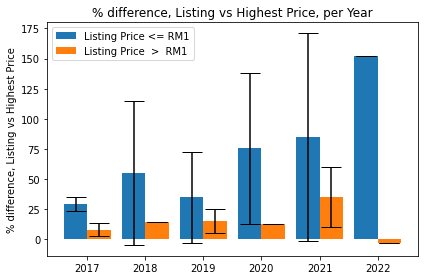

In [16]:
fig, ax = plt.subplots()
xpos = np.arange(len(barerr['lt1']))
width = 0.4
plt.bar(xpos-0.2, list(barheight['lt1'].values()), width, yerr=list(barerr['lt1'].values()), ecolor='black', capsize=10)
plt.bar(xpos+0.2, list(barheight['mt1'].values()), width, yerr=list(barerr['mt1'].values()), ecolor='black', capsize=10)

ax.set_xticks(xpos)
ax.set_xticklabels(years)
ax.set_ylabel('% difference, Listing vs Highest Price')
plt.title('% difference, Listing vs Highest Price, per Year')
plt.legend(["Listing Price <= RM1", "Listing Price  >  RM1"])

plt.tight_layout()
plt.show()

Similar to the above (analysis of % difference of listing vs opening price), we also see that there is an increasing trend of higher highest price in 2020 and 2021, as opposed to previous years, and it is more pronounced for IPOs at less than RM1. Again note the big standard deviation: the average suggests an increasing trend, yet there is a huge variation within the same year itself.

The similar trend for the two previous analysis is not surprising, since % difference of listing versus opening, and % difference of listing versus highest prices, actually correlate strongly:

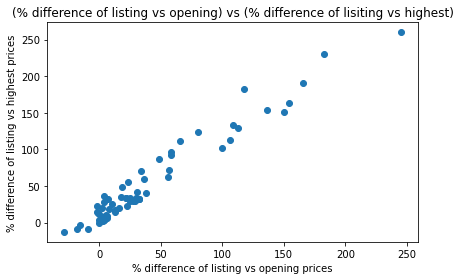

In [17]:
x_label = 'LISTVSOPENING_PCT'
y_label = 'LISTVSHIGHEST_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

ax.set_xlabel('% difference of listing vs opening prices')
ax.set_ylabel('% difference of listing vs highest prices')
    
plt.title('(% difference of listing vs opening) vs (% difference of lisiting vs highest)')
plt.tight_layout()
plt.show()

## Does high public interest during subscription translate into higher activity on IPO day?

Let's now remove analysis by year from the equation, and take the data as aggregate, and ask, if high oversubscription rate correlates into high volume on the counter on IPO day.

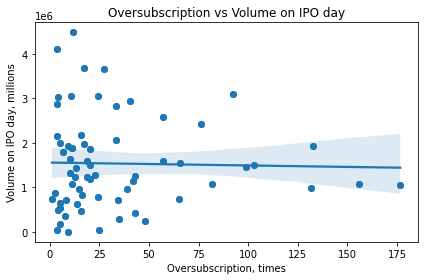

In [18]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'VOLUMEIPODAY'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription, times')
ax.set_ylabel('Volume on IPO day, millions')
    
plt.title('Oversubscription vs Volume on IPO day')
plt.tight_layout()
plt.show()

In [20]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print("P-value: ", round(p_value,4))
print("stderr: ", round(std_err,2))

R2:  -0.0414
P-value:  0.7451
stderr:  3584.21


From the plot and R-square value we can see there is a poor correlation between oversubscription rate and volume on the counter on IPO day.

<i>English speak:</i>
    
<i>R-square value ranges from -1 to 1, where -1 shows strong negative correlation, and 1 shows strong positive correlation. In this case the R-square is only around 0, suggesting there is no correlation.</i>
    
<i>For P-value, the range is from (close to) 0 to 1, where value close to 0 suggests that the value is strongly significant, while 1 suggests that it's probably not very good. What is a good P-value cutoff depends on the case, but for simple test typically statisticians set that P-values need to be maximum 0.05 (or 0.01 if they want to be more strict). Here we have ~0.7, which is rather large.</i>

This suggests that even if a counter was highly oversubscribed, this does not mean that there will be more participants on the counter on IPO day.

## Does high public interest during subscription translate into higher speculative activity on IPO day?
Okay, so it seems that subscription rate doesn't correlate with volume on IPO day. But does subscription rate correlate with higher speculative activity (not volume because we just answered that) on IPO day? i.e, the % difference between listing vs opening, listing vs highest, and maybe also, listing vs closing prices.

Let's see % difference between listing vs opening prices first...

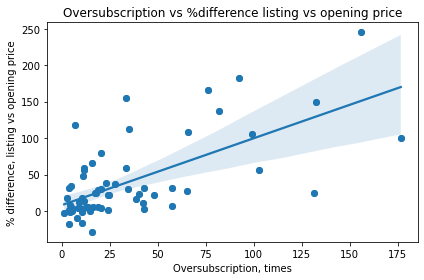

In [19]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSOPENING_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription, times')
ax.set_ylabel('% difference, listing vs opening price')

plt.title('Oversubscription vs %difference listing vs opening price')
plt.tight_layout()
plt.show()

In [20]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.6555
P-value: 2.3387e-09
stderr:  0.132
equation: y = 0.9165*X + 8.1523


Noice. Looks like there's rather good correlation: the higher public interest in subscribing to the IPO (as measured by the oversubscription rate), the higher likelihood that we'd see higher opening price on IPO day.

<i>We have R-square at ~0.6, quite far from 0 for no correlation. Also the P-value is really really small!</i>

This tells you that while there is no correlation between oversubscription with volume per se, the ones that participate during IPO day indeed push up the price at market open.

Let's remove points over 40X oversubscription rate, since outliers like those can easily skew the result.

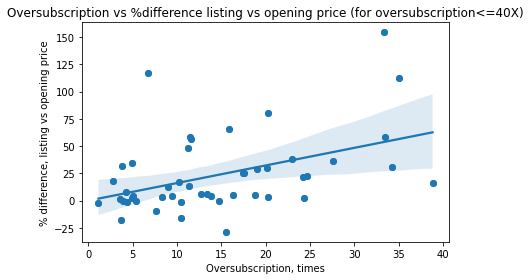

In [21]:
df2 = df[df['TOTALBALLOTINGOSCBED']<40]

x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSOPENING_PCT'
x = df2[x_label]
y = df2[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription, times')
ax.set_ylabel('% difference, listing vs opening price')

plt.title('Oversubscription vs %difference listing vs opening price (for oversubscription<=40X)')
plt.tight_layout()
plt.show()


In [22]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.4411
P-value: 1.6991e-03
stderr:  0.4842
equation: y = 1.6143*X + 0.0212


Yes, the result still holds, albeit with slightly lower R2 value. Noice.

Let's look at oversubscription vs %difference listing-to-highest price. I suspect it will also correlate (since I've already showed that % difference listing-to-opening already correlates with % difference listing-to-highest prices).

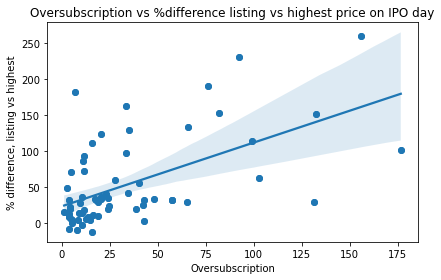

In [23]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSHIGHEST_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription')
ax.set_ylabel('% difference, listing vs highest')

plt.title('Oversubscription vs %difference listing vs highest price on IPO day')
plt.tight_layout()
plt.show()

In [24]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.5672
P-value: 6.8342e-07
stderr:  0.161
equation: y = 0.8871*X + 23.1671


Yup, same. 

The higher public interest in subscribing to the IPO, the higher likelihood that the price will be pushed to a really high level on IPO day.

So, again, high public interest to the IPO does not translate into more volume, but those that participate during the IPO day push up the price at market open, and also push up the price to a high level during the day.

Again, check for oversubscription less than 40X (it should still hold).

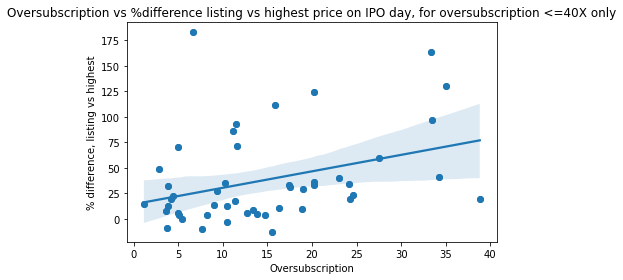

In [25]:
df2 = df[df['TOTALBALLOTINGOSCBED']<=40]
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSHIGHEST_PCT'
x = df2[x_label]
y = df2[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription')
ax.set_ylabel('% difference, listing vs highest')

plt.title('Oversubscription vs %difference listing vs highest price on IPO day, for oversubscription <=40X only')
plt.tight_layout()
plt.show()

In [26]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print("P-value: ", round(p_value,4))
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.3502
P-value:  0.0147
stderr:  0.6356
equation: y = 1.6115*X + 14.4463


Result holds, again with lower R-square and P-values.

Finally let's look at oversubscription vs %difference listing-to-closing price. Does the stock price tend to settle higher, if it has high oversubscription rate?

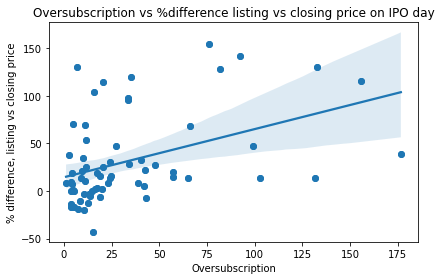

In [27]:
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSCLOSING_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription')
ax.set_ylabel('% difference, listing vs closing price')

plt.title('Oversubscription vs %difference listing vs closing price on IPO day')
plt.tight_layout()
plt.show()

In [28]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print(f"P-value: {p_value:.4e}")
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.4235
P-value: 3.9548e-04
stderr:  0.1352
equation: y = 0.5056*X + 14.4064


So, again, high public interest to the IPO does not translate into more volume, but those that participate during the IPO day push up the price at market open, and also push up the price to a high level during the day.

But you can see that the correlation is weaker now (R2 at 0.364) vs (R2 at ~0.6 for oversubscription vs % difference listing-vs-opening).

Again, just for completeness, let's verify for oversubscription less than 40X...

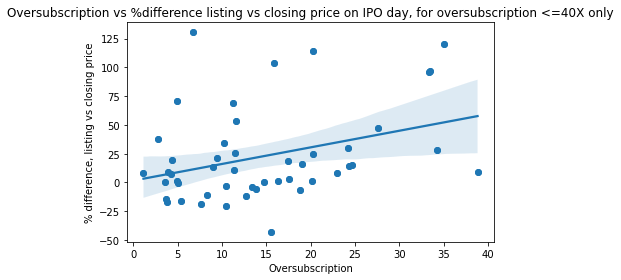

In [29]:
df = df[df['TOTALBALLOTINGOSCBED']<=40]
x_label = 'TOTALBALLOTINGOSCBED'
y_label = 'LISTVSCLOSING_PCT'
x = df[x_label]
y = df[y_label]
fig, ax = plt.subplots()
ax.scatter(x,y)

sns.regplot(x, y)

ax.set_xlabel('Oversubscription')
ax.set_ylabel('% difference, listing vs closing price')

plt.title('Oversubscription vs %difference listing vs closing price on IPO day, for oversubscription <=40X only')
plt.tight_layout()
plt.show()

In [30]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2: ", round(r_value,4))
print("P-value: ", round(p_value,4))
print("stderr: ", round(std_err,4))
print("equation: y = " + str(round(m,4)) + "*X + " + str(round(b,4)))

R2:  0.35
P-value:  0.0147
stderr:  0.5699
equation: y = 1.4443*X + 1.6476


Result holds, albeit with bit worse P-value.

## Summary
Okay, to summarize:
1. There's more interest from the public for IPO in recent years (i.e starting 2020)
    - with a general trend of higher price at market open and during trading day vs previous years.
2. Year 2020 we see the market is flush with liquidity, as there is high volume on an IPO counter.
    - this is in line with higher trading volume in 2020 on the the market overall as already covered elsewhere.
3. Higher oversubscription rate does not translate into higher volume on IPO day
4. Yet, higher oversubscription rate correlates with:
    - higher price at market open
    - higher price during trading day
    - higher price at market close

## More Questions
1. As we can collect the data (it's in the Internet, someone just have to do it) on IPO oversubscription for Bumi vs non-Bumi, do these two population groups show different trends over the years?
2. I did not collect data on the market cap or outstanding shares. Is it worth to see if there's any interesting patterns with regards to oversubscription rate, liquidity or % difference from listing price with market cap/#outstanding shares?
3. Also would be interesting to see how fast does trading volume on a recently IPOed counter wanes, when compared to their oversubscription rate or speculative activity on IPO day.

et cetera, et cetera.

Thanks for reading. Hope this worth your time.

<b>To close, I have to emphasize this again: This exercise is for entertainment purposes only. Do not trade shares based on this exercise. Trading shares involve capital loss and emotional pain. Please consult your investment advisor before embarking on any financial exercise.
At any trading day there can be wild swings in the market, IPOed shares included. You may be lucky 5 times, but it could take just 1  Do not trade shares based on this exercise.
</b>